# DOFB Architecture

In [1]:
%reset -f

# Python Control Systems Library
# https://python-control.readthedocs.io/en/latest/index.html

from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    import control
except ModuleNotFoundError:
    print("Could not find control - installing")
    !pip install control

try:
    import slycot
except ModuleNotFoundError:
    print("Could not find slycot - installing")
    !pip install slycot

import control
from control.matlab import *  # MATLAB-like functions
!pwd

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
from numpy import linalg as LA
r2d = 180/np.pi

Running Python: 3.8.16
Could not find slycot - installing
/Users/jonathanhow/Documents/GitHub/16_32_Private


$\newcommand{\bmat}{\begin{bmatrix}}
\newcommand{\emat}{\end{bmatrix}}
\newcommand{\expect}[1]{\expec\left[ #1 \right]}
\newcommand{\mb}{\mathbf}
\newcommand{\argmax}{\operatornamewithlimits{argmax}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\bea}{\begin{eqnarray}}
\newcommand{\eea}{\end{eqnarray}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\ba}{\begin{array}}
\newcommand{\ea}{\end{array}}
\newcommand{\njbv}{\mathbf{v}}
\newcommand{\njbr}{\mathbf{r}}
\newcommand{\njbw}{\mathbf{w}}
\newcommand{\njbx}{\mathbf{x}}
\newcommand{\njby}{\mathbf{y}}
\newcommand{\njbu}{\mathbf{u}}
\newcommand{\njbe}{\mathbf{e}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
$
## Basic Reference Input Approach 

Assume that we have designed $K$ and $L$ using LQR/LQE - now consider how we implement them to follow a reference command - we have various options. These options **do not** change the closed-loop pole locations, but they **do** significantly impact the reference tracking response. Why? they change the zeros of the tracking loop. (see https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7741010)

Define the tracking error as $\njbe(t) = \njbr(t) - \njby(t)$, then the form of the controller will be
\begin{eqnarray*}
\dot {\njbx}_c(t) &=& (A-BK-LC) \njbx_c(t) + L \njbe(t) \\
\njbu(t)&=& K \njbx_c(t) 
\end{eqnarray*}
Note that if $\njbr(t) = 0$ (i.e. no reference input, which was the case discussed before), then $\njbe(t) = -\njby(t)$, giving a minus sign on the compensator input that we can move to the output, giving the same form as written before.

In [2]:
A = np.array([[0, 1],[-1, -1]])
Bu = np.array([[0],[1]])
Bw = Bu
Cy = np.array([[1,0]])
Cz = np.eye(2)
Rzz = np.array([[1, 0],[0, 0.1]])
sys_g = StateSpace(A, Bu, Cy, 0)

Nx = A.shape[0]
Ny = Cy.shape[0]
Nu = Bu.shape[1]

# Gains picked using pole placement
K = np.array([[31,7]])  
L = np.array([[19],[80]])
EQ,_ = LA.eig(A-L@Cy)
EP,_ = LA.eig(A-Bu*K)

# Form LQG compensator (basic form)
Ac = A - Bu@K - L@Cy
Bc = L
Cc = K 
Dc = 0
sys_comp = StateSpace(Ac,Bc,Cc,Dc)
T_loop = sys_g*sys_comp 

# Form closed loop system (basic)
Acl = np.vstack((np.hstack((A,-Bu@Cc)),np.hstack((Bc@Cy,Ac))))
Bcl = np.vstack((np.zeros((Nx,Ny)), Bc ))
Ccl = np.hstack((Cy, np.zeros((Ny,Nx)) ))
Dcl = 0
Ncl = -1/(Ccl@LA.inv(Acl)@Bcl) # scaling to ensure that y step response is 1
sys_cl = StateSpace(Acl,Bcl,Ccl,Dcl)

print('Eigenvalues of the system')
P_s = LA.eigvals(A)
print(np.vstack(P_s),'\n')

print('Eigenvalues of the closed loop system')
P_cl = LA.eigvals(Acl)
print(np.vstack(P_cl),'\n')
print('Should be the same as estimator and regulator poles:')
print(np.vstack(EQ))
print(np.vstack(EP),'\n')

print('Eigenvalues of the compensator')
P_comp=control.matlab.pole(sys_comp)
Z_comp=control.matlab.zero(sys_comp)
print(np.vstack(P_comp),'\n')
print('Zeros of the compensator')
print(np.vstack(Z_comp),'\n')

Eigenvalues of the system
[[-0.5+0.8660254j]
 [-0.5-0.8660254j]] 

Eigenvalues of the closed loop system
[[-10.00000032+0.j]
 [ -9.99999968+0.j]
 [ -4.        +4.j]
 [ -4.        -4.j]] 

Should be the same as estimator and regulator poles:
[[-10.0000]
 [-10.0000]]
[[-4.+4.j]
 [-4.-4.j]] 

Eigenvalues of the compensator
[[-13.5+9.04157066j]
 [-13.5-9.04157066j]] 

Zeros of the compensator
[[-2.55526545+0.j]] 



In [3]:
Acl

array([[   0,    1,    0,    0],
       [  -1,   -1,  -31,   -7],
       [  19,    0,  -19,    1],
       [  80,    0, -112,   -8]])

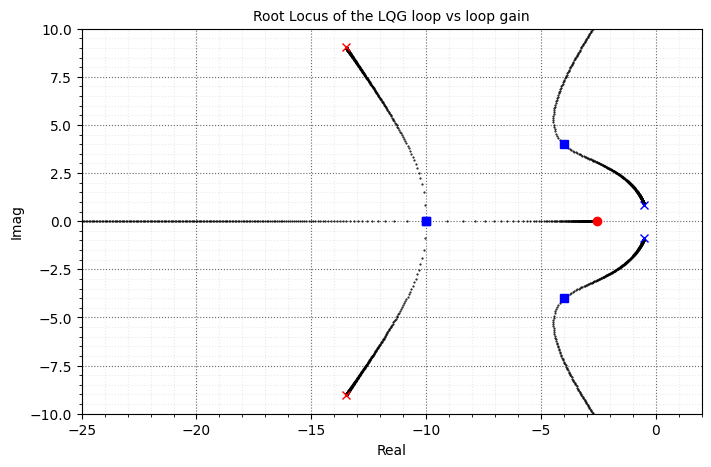

In [4]:
plt.figure(3,figsize=(8,5))
ax2 = plt.subplot(111)
rlist = control.root_locus(T_loop,kvect=np.logspace(-2,2,num=1000),plot=False)
ax2.plot(rlist[0].real,rlist[0].imag,'k.',ms=1)
ax2.plot(P_cl.real,P_cl.imag,'bs',ms=6)
ax2.plot(P_s.real,P_s.imag,'bx',ms=6)
ax2.plot(P_comp.real,P_comp.imag,'rx',ms=6)
ax2.plot(Z_comp.real,Z_comp.imag,'ro',ms=6)
nicegrid(ax2)
ax2.set_xlim([-25,2])
ax2.set_ylim([-10,10])
plt.title('Root Locus of the LQG loop vs loop gain')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.savefig("figs/LQG_Arch_1.png")   
plt.show()

## Loop TF

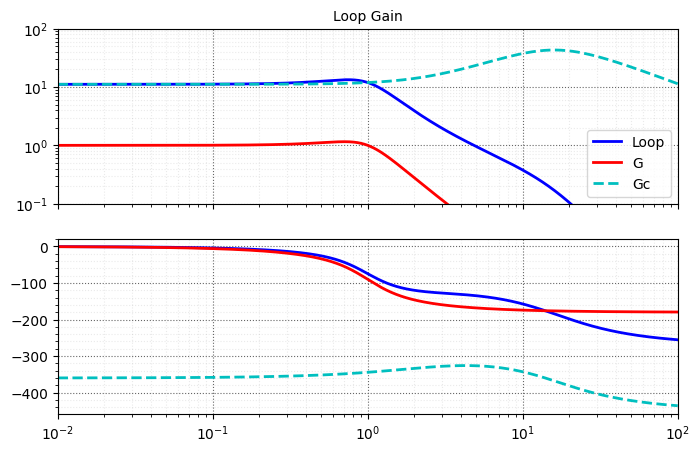

In [5]:
w = np.logspace(-2,2,1000)
mag,phase,omega = control.bode(T_loop,w,Hz=False,dB=False,deg=True,plot=False)
mag_gc,phase_gc,omega = control.bode(sys_comp,w,Hz=False,dB=False,deg=True,plot=False)
mag_g,phase_g,omega = control.bode(sys_g,w,Hz=False,dB=False,deg=True,plot=False)

fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(8,5))
ax1.loglog(w,mag,'b',label='Loop')                 # magnitude plot
ax1.loglog(w,mag_g,'r',label='G')                 # magnitude plot
ax1.loglog(w,mag_gc,'c--',label='Gc')                 # magnitude plot
ax1.set_title("Loop Gain")
ax1.set_xlim([.01,100])
ax1.set_ylim([.1,100])
ax1.legend(loc='best')
nicegrid(ax1)

ax2.semilogx(w,phase*r2d,'b',label='Loop')                 # phase plot
ax2.semilogx(w,phase_g*r2d,'r',label='G')                 # phase plot
ax2.semilogx(w,phase_gc*r2d,'c--',label='Gc')                 # phase plot
ax2.set_xlim([.01,100])
nicegrid(ax2)
plt.savefig("figs/LQG_Arch_2.png")   

plt.show()

## Sensitivity TF

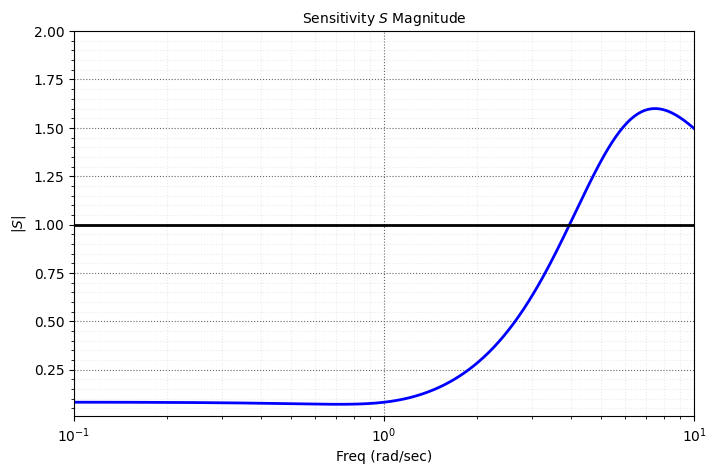

In [6]:
S = control.feedback(ss(0,0,0,1),sys_g*sys_comp)
mag,phase,omega = control.bode(S,w,Hz=False,dB=False,deg=True,plot=False)

fig, (ax1) = plt.subplots(1, sharex=True, figsize=(8,5))
plt.semilogx(w,mag,'b')
nicegrid()
plt.xlim([.1,10])
plt.ylim([.01,2])
plt.plot(plt.xlim(),[1,1],'k-')
plt.xlabel('Freq (rad/sec)')
plt.ylabel('$|S|$')
plt.title("Sensitivity $S$ Magnitude")
plt.savefig("figs/LQG_Arch_3.png")   
plt.show()

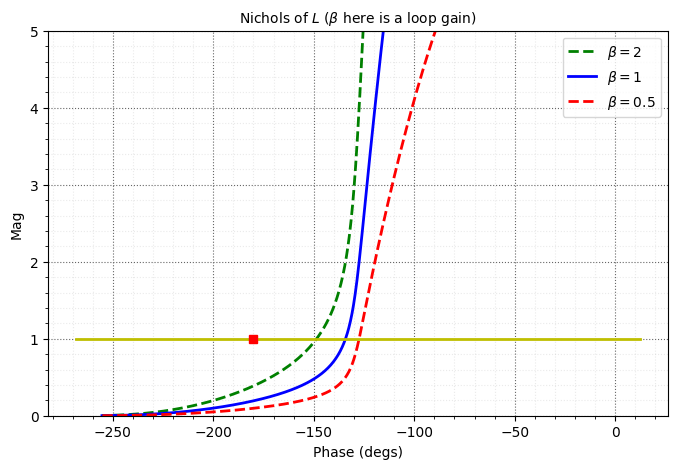

In [7]:
L_mag,L_phase,omega = control.bode(T_loop,w,Hz=False,dB=False,deg=True,plot=False)

fig, (ax1) = plt.subplots(1, sharex=True, figsize=(8,5))
plt.plot(L_phase*r2d,2*L_mag,'g--',label=r'$\beta=2$')
plt.plot(L_phase*r2d,L_mag,label=r'$\beta=1$')
plt.plot(L_phase*r2d,0.5*L_mag,'r--',label=r'$\beta=0.5$')
nicegrid()
plt.plot(plt.xlim(),[1,1],'y-')
plt.plot(-1*180,1,'rs')
plt.ylim([0,5])
#plt.xlim([-560,-360])
plt.xlabel('Phase (degs)')
plt.ylabel('Mag')
plt.title(r"Nichols of $L$ ($\beta$ here is a loop gain)")
plt.legend()
plt.savefig("figs/LQG_Arch_4.png")   
plt.show()

## Step Responses

In [8]:
# Closed-loop assuming LQR 
Alqr = A-Bu*K
Blqr = Bu
Clqr = Cy
Dlqr = 0
Nlqr = -1/(Clqr@LA.inv(Alqr)@Blqr) # scaling to ensure that y step response is 1
sys_lqr = StateSpace(Alqr,Blqr,Clqr,Dlqr)

# Step response of the various systems
tf = 3
x0 = 0
v0= 0
X02 = np.array([[x0, v0]]) # LQR CL IC
X0 = np.array([[x0, v0, 0, 0]])  # LQG CL IC

time = np.linspace(0, tf, 301)
T ,y1, Xcl = control.step_response(sys_cl*Ncl, time, X0.T,return_x=True,squeeze=True)
T2 ,y2, Xcl2 = control.step_response(sys_lqr*Nlqr, time, X02.T,return_x=True,squeeze=True)


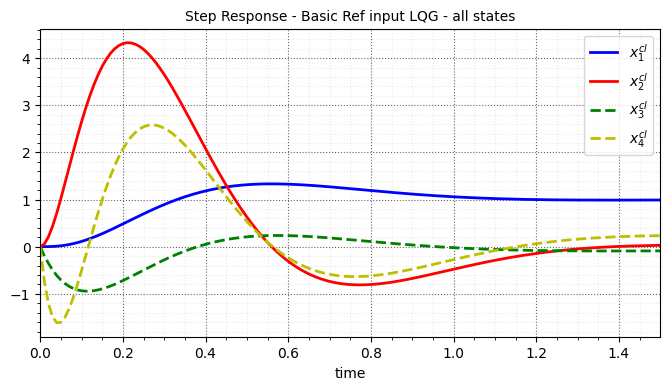

In [9]:
plt.figure(1,figsize=(8,4))
ax1 = plt.subplot(111)
ax1.plot(time,Xcl[0,:],'b',label=r'$x^{cl}_1$')
ax1.plot(time,Xcl[1,:],'r',label=r'$x^{cl}_2$')
ax1.plot(time,Xcl[2,:],'g--',label=r'$x^{cl}_3$')
ax1.plot(time,Xcl[3,:],'y--',label=r'$x^{cl}_4$')
plt.legend(loc='best')
plt.title('Step Response - Basic Ref input DOFB - all states')
nicegrid()
plt.xlim([0, tf/2])
plt.xlabel('time')
plt.savefig("figs/LQG_Arch_5.png")   
plt.show()

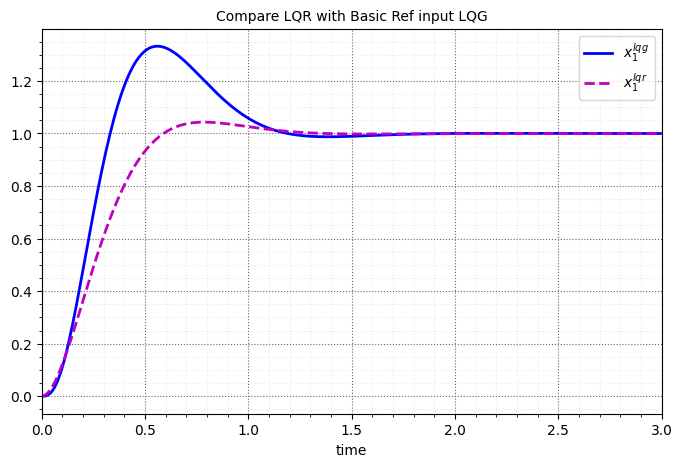

In [10]:
plt.figure(2,figsize=(8,5))
ax1 = plt.subplot(111)
ax1.plot(time,Xcl[0,:],'b',label=r'$x^{lqg}_1$')
#ax1.plot(time,Xcl[1,:],'r',label=r'$x^{lqg}_2$')
ax1.plot(time,Xcl2[0,:],'m--',label=r'$x^{lqr}_1$')
#ax1.plot(time,Xcl2[1,:],'c--',label=r'$x^{lqr}_2$')
plt.xlabel('time')
plt.legend(loc=1)
plt.title('Compare LQR with Basic Ref input DOFB')
nicegrid()
plt.xlim([0, tf])
plt.savefig("figs/LQG_Arch_6.png")   
plt.show()

$\newcommand{\bmat}{\begin{bmatrix}}
\newcommand{\emat}{\end{bmatrix}}
\newcommand{\expect}[1]{\expec\left[ #1 \right]}
\newcommand{\mb}{\mathbf}
\newcommand{\argmax}{\operatornamewithlimits{argmax}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\bea}{\begin{eqnarray}}
\newcommand{\eea}{\end{eqnarray}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\ba}{\begin{array}}
\newcommand{\ea}{\end{array}}
\newcommand{\njbv}{\mathbf{v}}
\newcommand{\njbr}{\mathbf{r}}
\newcommand{\njbw}{\mathbf{w}}
\newcommand{\njbx}{\mathbf{x}}
\newcommand{\njby}{\mathbf{y}}
\newcommand{\njbu}{\mathbf{u}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
$
# Improved Reference Input Approach 
The controller:
\begin{eqnarray*}
\dot {\njbx}_c(t) &=& (A-BK-LC) \njbx_c(t) + L \njby(t) + B\overline N\njbr(t) \\
\njbu(t)&=& - K \njbx_c(t) + \overline N \njbr(t)
\end{eqnarray*}
can be rewritten as:
\begin{eqnarray*}
\dot {\njbx}_c(t) &=& (A-LC) \njbx_c(t) + L \njby(t) + B \njbu(t) \\
\njbu(t)&=& - K \njbx_c(t) + \overline N \njbr(t)
\end{eqnarray*}
So the control is computed using the reference 
	before it is applied, and that control is applied to both system 
	and estimator.

This has the benefit of canceling out the estimator dynamics (pole zero cancelation), which improvrsthe step response.

In [11]:
# Form LQG compensator (better input form)
Ac2 = A - Bu@K - L@Cy
Abar = np.vstack((np.hstack((A,-Bu@K)),np.hstack((L@Cy,Ac2)))) # note sign difference from above
Bbar = np.vstack((Bu, Bu))
Nbar = -1/(Ccl@LA.inv(Abar)@Bbar) # scaling to ensure that y step response is 1
# Form closed loop system (better)
sys_cl2 = StateSpace(Abar,Bbar,Ccl,Dcl)
T3 ,y3, Xcl3 = control.step_response(sys_cl2*Nbar, time, X0.T,return_x=True,squeeze=True)

P_cl2=control.matlab.pole(sys_cl2)
Z_cl2=control.matlab.zero(sys_cl2)
print('Closed loop poles are:')
print(np.vstack(P_cl2),'\n')
print('Closed loop zeros are:')
print(np.vstack(Z_cl2),'\n')
print('Recall: estimator poles are')
print(np.vstack(EQ),'\n')
print('which are canceled by the zeros in the closed-loop from the ref input, leaving the regulator response only.')


Closed loop poles are:
[[-10.00000032+0.j]
 [ -9.99999968+0.j]
 [ -4.        +4.j]
 [ -4.        -4.j]] 

Closed loop zeros are:
[[-10.+3.58572101e-07j]
 [-10.-3.58572101e-07j]] 

Recall: estimator poles are
[[-10.0000]
 [-10.0000]] 

which are canceled by the zeros in the closed-loop from the ref input, leaving the regulator response only.


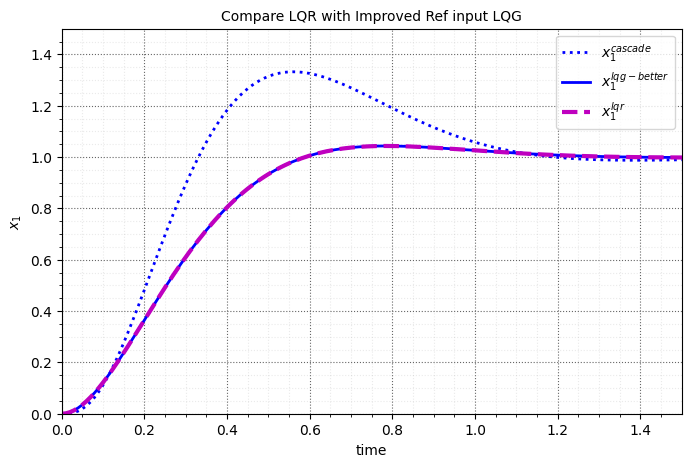

In [12]:
plt.figure(2,figsize=(8,5))
ax1 = plt.subplot(111)
ax1.plot(T,Xcl[0,:],'b:',label=r'$x^{cascade}_1$')
ax1.plot(T2,Xcl3[0,:],'b',lw=2,label=r'$x^{lqg-better}_1$')
ax1.plot(T3,Xcl2[0,:],'m--',lw=3,label=r'$x^{lqr}_1$')
plt.xlabel('time')
plt.ylabel(f'$x_1$')
plt.legend(loc='best')
nicegrid()
plt.xlim([0, tf/2])
plt.ylim([0, 1.5])
plt.title('Compare LQR with Improved Ref input DOFB')
plt.savefig("figs/LQG_Arch_7.png")   
plt.show()

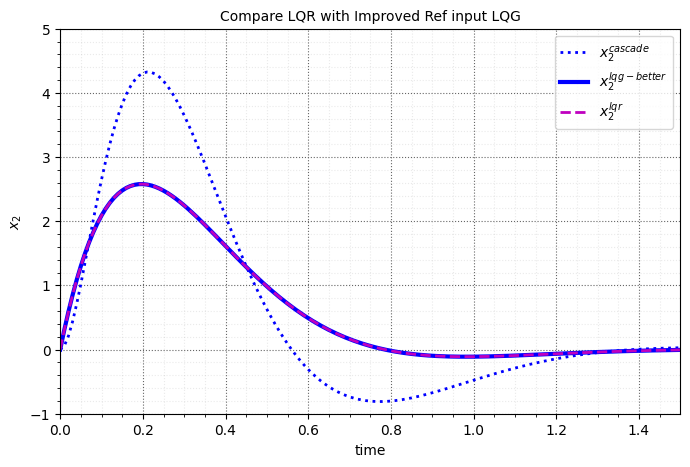

In [13]:
plt.figure(3,figsize=(8,5))
ax1 = plt.subplot(111)
ax1.plot(T,Xcl[1,:],'b:',label=r'$x^{cascade}_2$')
ax1.plot(T2,Xcl3[1,:],'b',lw=3,label=r'$x^{lqg-better}_2$')
ax1.plot(T3,Xcl2[1,:],'m--',lw=2,label=r'$x^{lqr}_2$')
plt.xlabel('time')
plt.ylabel(f'$x_2$')
plt.legend(loc='best')
nicegrid()
plt.xlim([0, tf/2])
plt.ylim([-1, 5])
plt.title('Compare LQR with Improved Ref input DOFB')
plt.savefig("figs/LQG_Arch_7a.png")   
plt.show()